In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import mlflow
import mlflow.pytorch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from utils.lstm_ativacao import LSTMAtivacao
from utils.carregar_modelo import carregar_modelo_completo
import os

### Challenge:

- predizer o valor de fechamento da bolsa de valores de uma empresa 
- pipeline de desenvolvimento:
    - criação do modelo preditivo
    - deploy do modelo em uma API que permita a previsão de preços de ações

In [3]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Dados históricos:

- techfase4\process\get_data.ipynb
- tensores não aceitam string nem datas

In [49]:
df0 = pd.read_pickle("../data/dados.pkl")
df0["Date"] = pd.to_datetime(df0["Date"])
df0["Timestamp"] = df0["Date"].astype("int64") // 10**9  # segundos desde 1970

In [50]:
df = df0.sort_values("Date")
df = df.drop(columns=["Date", 'Volume', 'Ticker'])

In [51]:
df.head()

,Close,High,Low,Open,Timestamp
0,137.391541,137.623750,136.444877,137.087896,1514851200
1,138.025650,138.418608,136.632446,136.632446,1514937600
2,139.659973,140.088648,138.222113,138.427517,1515024000
3,140.812042,140.856699,139.436704,139.865379,1515110400
4,141.937332,142.008780,140.070796,140.544128,1515369600


### Inspecionando os dados para definição da janela temporal

In [52]:
df.describe()

,Close,High,Low,Open,Timestamp
count,1886.000000,1886.000000,1886.000000,1886.000000,1.886000e+03
mean,249.981713,252.312013,247.558341,249.852386,1.633012e+09
std,74.017019,74.724710,73.355299,74.013796,6.832791e+07
min,121.532257,124.487145,120.586719,122.559674,1.514851e+09
25%,175.060486,176.399949,173.499743,175.099675,1.573711e+09
50%,266.379333,268.394702,263.556178,265.185176,1.632917e+09
75%,308.091087,311.442894,305.851461,308.207715,1.692122e+09
max,396.284912,396.384425,391.758147,394.201458,1.751501e+09


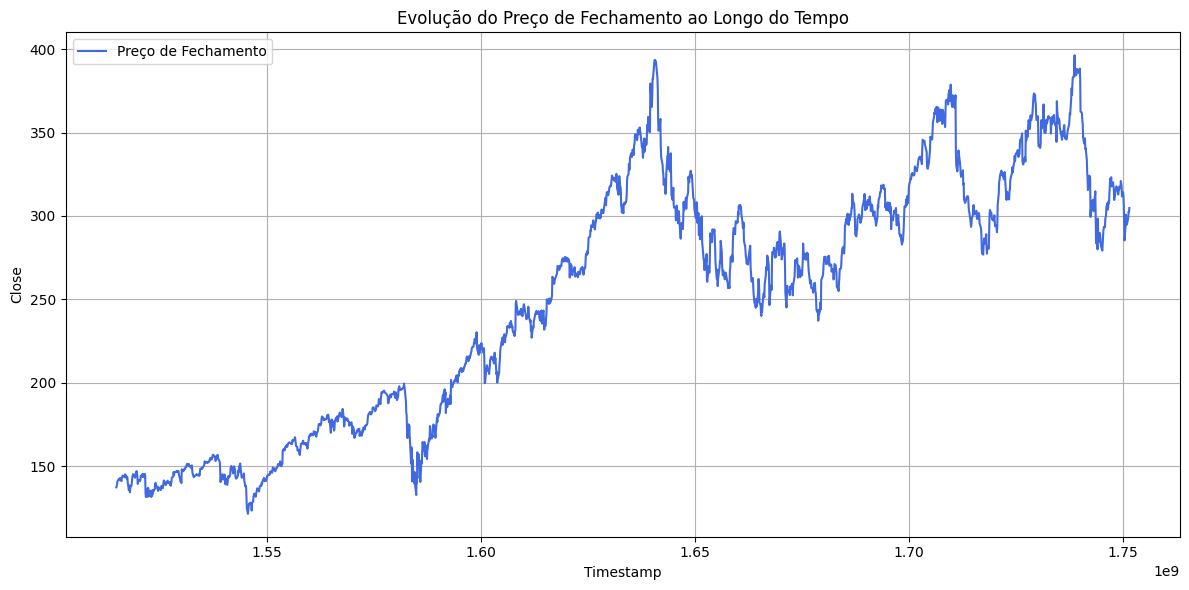

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(df["Timestamp"], df["Close"], label="Preço de Fechamento", color="royalblue")
plt.xlabel("Timestamp")
plt.ylabel("Close")
plt.title("Evolução do Preço de Fechamento ao Longo do Tempo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Normalização dos dados

1. Coluna Ticker, categórica, converter para numérica

In [ ]:
# df["Ticker"] = LabelEncoder().fit_transform(df["Ticker"])
# tickers = df["Ticker"]

In [54]:
df.head()

,Close,High,Low,Open,Timestamp
0,137.391541,137.623750,136.444877,137.087896,1514851200
1,138.025650,138.418608,136.632446,136.632446,1514937600
2,139.659973,140.088648,138.222113,138.427517,1515024000
3,140.812042,140.856699,139.436704,139.865379,1515110400
4,141.937332,142.008780,140.070796,140.544128,1515369600


### Criando sequências para LSTM:
- Modelos LSTM (Long Short-Term Memory) não aprendem apenas com os dados atuais, mas com janelas do passado.
- Eles precisam ver os últimos n passos no tempo para prever o próximo valor.
- A função create_sequences cria exatamente essas janelas.
- O tamanho da sequência: quantos passos de tempo o modelo vai olhar de uma vez. Ex: 20 dias passados do dado por input.

In [55]:
def create_sequences(data, sequence_length, target_index):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i][target_index])
    return np.array(X), np.array(y)

In [56]:
sequence_length = 50 

In [57]:
target_index = df.columns.get_loc("Close")
data_array = df.to_numpy()
X_seq, y_seq = create_sequences(data_array, sequence_length, target_index)

### Convertendo para tensores e DataLoader

In [58]:
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [59]:
num_features = X_tensor.shape[2]
print("Number of features:", num_features)

Number of features: 5


In [60]:
df.shape

(1886, 5)

### LSTM

In [61]:
# Hyperparameters
input_size = X_tensor.shape[2]      # Number of features in the input data
hidden_size = 100     # Number of hidden units in the LSTM
num_layers = 3       # Number of LSTM layers
output_size = 1      # prever apenas o Close, sai um vetor, aqui está um numero
num_epochs = 100
batch_size = 64
learning_rate = 0.001
num_samples = 10000  # Number of artificial samples to generate

### Testando 3 opções de ativações para escolher a melhor

In [62]:
ativacoes = {
    "ReLU": nn.ReLU(),
    "Tanh": nn.Tanh(),
    "Sem_Ativacao": nn.Identity()
}

### Classe criada em arquivo separado (lstm_ativacao.py) para ser também usada no app.py

In [63]:
def avaliar_modelo(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            output = model(X_batch).squeeze()
            y_true.extend(y_batch.numpy())
            y_pred.extend(output.numpy())

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    return y_true, y_pred, mae, mse

### Rodando o modelo com diferentes ativações

Treinando com ativação: ReLU


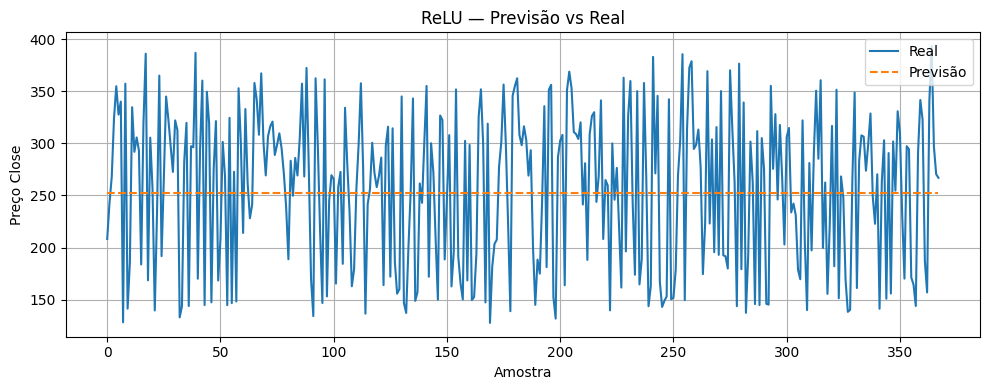

Treinando com ativação: Tanh


KeyboardInterrupt: 

In [65]:
resultados = {}
modelos_salvos = {}

for nome, funcao in ativacoes.items():
    print(f"Treinando com ativação: {nome}")
    
    model = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, funcao).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Início do experimento no MLflow
    mlflow.set_experiment("LSTM Artificial Data Regression")
    with mlflow.start_run(run_name=f"Ativação: {nome}"):
        # Log dos parâmetros
        mlflow.log_param("activation", nome)
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("output_size", output_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        
        # Treinamento
        for epoch in range(num_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Avaliação
        y_true, y_pred, mae, mse = avaliar_modelo(model, test_loader)
        resultados[nome] = {"MAE": mae, "MSE": mse}
        modelos_salvos[nome] = model.state_dict()  # Salva na memória

        # Log das métricas
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)

        # Log do gráfico (opcional — salvar e enviar)
        plt.figure(figsize=(10, 4))
        plt.plot(y_true, label="Real")
        plt.plot(y_pred, linestyle="--", label="Previsão")
        plt.title(f"{nome} — Previsão vs Real")
        plt.xlabel("Amostra")
        plt.ylabel("Preço Close")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show()

### Avaliando o resultado

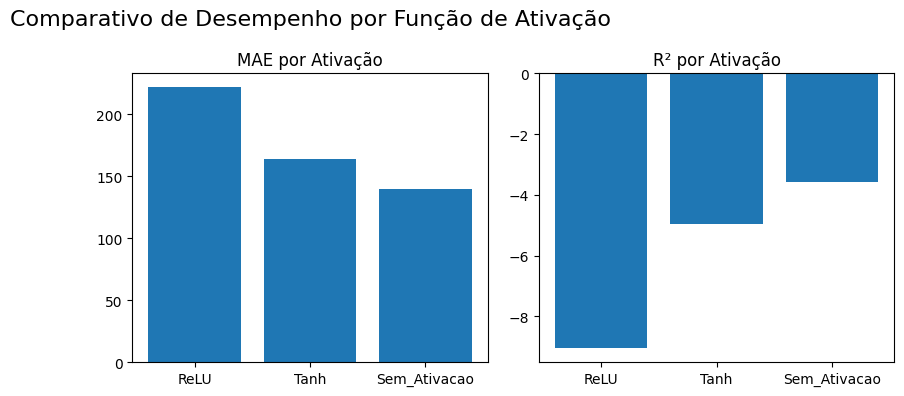

In [19]:
labels = list(resultados.keys())
mae_vals = [resultados[k]["MAE"] for k in labels]
r2_vals  = [resultados[k]["R2"] for k in labels]

x = np.arange(len(labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 2)
plt.bar(x, mae_vals, tick_label=labels)
plt.title("MAE por Ativação")

plt.subplot(1, 3, 3)
plt.bar(x, r2_vals, tick_label=labels)
plt.title("R² por Ativação")

plt.suptitle("Comparativo de Desempenho por Função de Ativação", fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
print("Modelos salvos disponíveis:", modelos_salvos.keys())

Modelos salvos disponíveis: dict_keys(['ReLU', 'Tanh', 'Sem_Ativacao'])


### Selecionado o melhor modelo

In [ ]:
r2 para problemas lineares pegar mae e mse

In [59]:
# Seleção do melhor modelo com base no menor MAE
melhor_ativacao = min(resultados, key=lambda k: resultados[k]["MAE"])
melhor_mae = resultados[melhor_ativacao]["MAE"]
melhor_r2 = resultados[melhor_ativacao]["R2"]

print(f"\n⭐ Melhor ativação: {melhor_ativacao}")
print(f"🔹 MAE: {melhor_mae:.4f} | R²: {melhor_r2:.4f}")

# Carrega o modelo correspondente
melhor_modelo = LSTMAtivacao(input_size, hidden_size, num_layers, output_size, ativacoes[melhor_ativacao]).to(device)
melhor_modelo.load_state_dict(modelos_salvos[melhor_ativacao])
melhor_modelo.eval()



⭐ Melhor ativação: Tanh
🔹 MAE: 3.8499 | R²: 0.9949


LSTMAtivacao(
  (lstm): LSTM(11, 50, num_layers=2, batch_first=True)
  (regressor): Sequential(
    (0): Tanh()
    (1): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Fazendo novas previsões

In [60]:
def multi_step_forecast(model, last_sequence, steps_ahead):
    model.eval()
    preds = []
    seq = last_sequence.clone().detach()

    for _ in range(steps_ahead):
        with torch.no_grad():
            out = model(seq.unsqueeze(0))  # formato (1, seq_len, n_features)
            preds.append(out.item())

            # Cria próxima sequência com a previsão
            new_step = seq[-1].clone()
            new_step[0] = out  # coloca o novo valor de 'Close'
            seq = torch.cat((seq[1:], new_step.unsqueeze(0)), dim=0)

    return preds

In [61]:
last_seq = X_tensor[-1]  # última sequência do dataset
steps_ahead=30
multi_preds = multi_step_forecast(melhor_modelo, last_seq, steps_ahead)

In [62]:
close_index = df_num.columns.get_loc("Close")
scaler_close = MinMaxScaler()
scaler_close.min_ = scaler.min_[close_index:close_index+1]
scaler_close.scale_ = scaler.scale_[close_index:close_index+1]

In [63]:
multi_preds_descaled = scaler_close.inverse_transform(np.array(multi_preds).reshape(-1, 1)).flatten()

In [64]:
# Última data conhecida dataset original
last_date = df0["Date"].max()  # ou df.index.max() se estiver no índice
last_date

Timestamp('2025-06-27 00:00:00')

In [65]:
# Número de passos previstos
steps_ahead = len(multi_preds)

# Gera as datas futuras
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps_ahead, freq='D')
future_dates = future_dates.strftime('%Y/%m/%d')


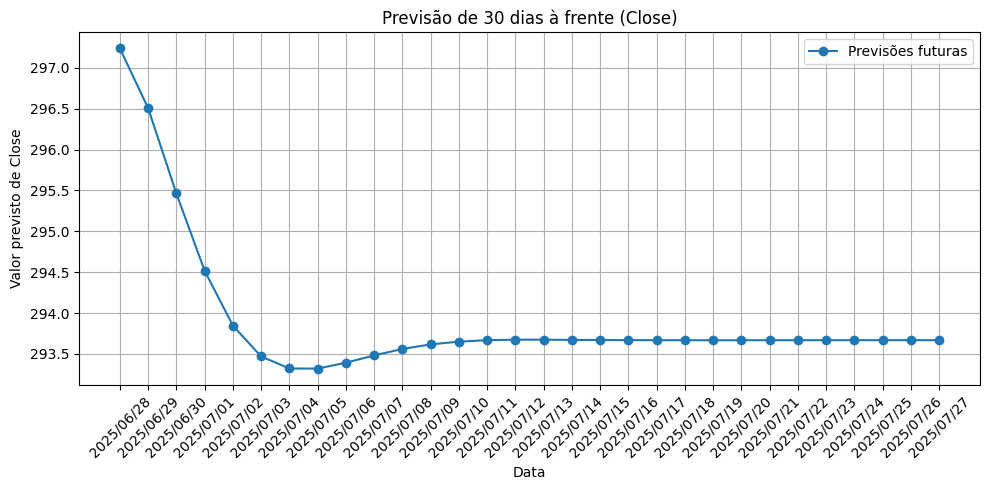

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(future_dates, multi_preds_descaled, marker='o', label="Previsões futuras")
plt.title(f"Previsão de {steps_ahead} dias à frente (Close)")
plt.xlabel("Data")
plt.ylabel("Valor previsto de Close")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Salvando o modelo

In [67]:
#torch.save(melhor_modelo.state_dict(), "modelo_lstm_v2.pth")

In [68]:
def salvar_modelo_completo(model, input_size, hidden_size, num_layers, output_size,
                           ativacao_nome, scaler, scaler_y, caminho_modelo="modelo_lstm.pt",
                           caminho_scaler="scaler.pkl", caminho_scaler_y="scaler_y.pkl"):
    # Salva o modelo e metadados
    torch.save({
        "model_state": model.state_dict(),
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "activation": ativacao_nome
    }, caminho_modelo)

    # Salva os scalers com joblib
    joblib.dump(scaler, caminho_scaler)
    joblib.dump(scaler_y, caminho_scaler_y)

    print(f"Modelo e scalers salvos com sucesso: {caminho_modelo}, {caminho_scaler}, {caminho_scaler_y}")

In [69]:
salvar_modelo_completo(
    model=melhor_modelo,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    ativacao_nome=melhor_ativacao,
    scaler=scaler,
    scaler_y=scaler_y
)

Modelo e scalers salvos com sucesso: modelo_lstm.pt, scaler.pkl, scaler_y.pkl


In [ ]:
print("Modelo espera input_size =", melhor_modelo.lstm.input_size)

Modelo espera input_size = 11


In [74]:
print("Scaler transforma", len(scaler.feature_names_in_), "features")

Scaler transforma 10 features


In [ ]:
### Carregando o modelo salvo
# # Caminhos absolutos
# BASE_DIR = os.getcwd()
# model_path = os.path.join(BASE_DIR, "modelo_lstm.pt")
# scaler_path = os.path.join(BASE_DIR, "scaler.pkl")
# scaler_y_path = os.path.join(BASE_DIR, "scaler_y.pkl")

# # Carrega modelo e scalers
# model, scaler, scaler_y = carregar_modelo_completo(model_path, scaler_path, scaler_y_path)
# print(model_path)